# Instacart Market Basket Analysis データセットを用いた Pandas と Polars の比較


このノートブックでは、Instacart Market Basket Analysis データセットを用いて、Pandas と Polars (Eager および Lazy モード) のパフォーマンス比較を行います。特に、以下の観点から比較を行います。

- 処理時間: 各ライブラリがデータ処理タスクを完了するのにかかる時間。
- メモリ使用量: 各ライブラリがデータ処理タスクを実行する際に使用するメモリ量。

## ライブラリのインストールとインポート


In [ ]:
!pip install japanize-matplotlib
!pip install kaggle
!pip install polars

In [ ]:
import polars as pl
import pandas as pd
import time
import os
import json
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import japanize_matplotlib
import zipfile

## データセットのダウンロードと準備

### Kaggle API を使用したデータセットのダウンロード

In [ ]:
data_dir = '/content/'

# kaggle.jsonのアップロード
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

with open(fn, 'r') as f:
  kaggle_data = json.load(f)
  os.environ['KAGGLE_USERNAME'] = kaggle_data['username']
  os.environ['KAGGLE_KEY'] = kaggle_data['key']

print("Kaggle Username:", os.environ.get('KAGGLE_USERNAME'))
print("Kaggle Key:", os.environ.get('KAGGLE_KEY') != None)

import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
# Kaggle APIの認証
api = KaggleApi()
api.authenticate()


### データセットのダウンロード&解凍 (Instacart Market Basket Analysis)

In [ ]:
api.competition_download_files('instacart-market-basket-analysis', path=data_dir)

with zipfile.ZipFile(os.path.join(data_dir, 'instacart-market-basket-analysis.zip'), 'r') as zip_ref:
  zip_ref.extractall(data_dir)


os.remove(os.path.join(data_dir, 'instacart-market-basket-analysis.zip'))

for file in os.listdir(data_dir):
    if file.endswith('.zip'):
        with zipfile.ZipFile(os.path.join(data_dir, file), 'r') as zip_ref:
            zip_ref.extractall(data_dir)

for file in os.listdir(data_dir):
    if file.endswith('.zip'):
        os.remove(os.path.join(data_dir, file))

## データ処理と分析

### *商品データと部門データの処理*

商品のデータセット (products) と部門のデータセット (departments) を使用して、各部門に属する商品の数を集計する。

In [ ]:
# Pandas
def process_with_pandas(products_filepath, departments_filepath):
    products_df = pd.read_csv(products_filepath)
    departments_df = pd.read_csv(departments_filepath)
    result_pandas = products_df['department_id'].value_counts().reset_index().merge(departments_df, on='department_id')[['department', 'count']]
    result_pandas = result_pandas.sort_values('count', ascending=False)
    return result_pandas

# Polars (Eager)
def process_with_polars_eager(products_filepath, departments_filepath):
    products_pl_df = pl.read_csv(products_filepath)
    departments_pl_df = pl.read_csv(departments_filepath)
    result_polars_eager = products_pl_df.group_by("department_id").agg(
        pl.count().alias("count")
    ).join(departments_pl_df, on="department_id").select(["department", "count"])
    result_polars_eager = result_polars_eager.sort("count", descending=True)
    return result_polars_eager

# Polars (Lazy)
def process_with_polars_lazy(products_filepath, departments_filepath):
    products_pl_df = pl.scan_csv(products_filepath)
    departments_pl_df = pl.scan_csv(departments_filepath)
    result_polars_lazy = products_pl_df.group_by("department_id").agg(
        pl.count().alias("count")
    ).join(departments_pl_df, on="department_id").select(["department", "count"]).sort("count", descending=True).collect()
    return result_polars_lazy

### 顧客行動分析

顧客の注文データ (orders) を分析し、顧客の行動に関する(と思われる)指標の算出。

- 平均注文回数 (avg_num_orders): 顧客一人当たりの平均注文回数。
- 平均注文間隔 (avg_time_between_orders): 顧客が注文してから次の注文をするまでの平均日数。
- 顧客ごとの平均注文間隔 (user_avg_interval_df): 各顧客の注文間隔の平均値を格納したDF

In [ ]:
# Pandas
def analyze_customer_behavior_pandas(orders_filepath):
    orders_df = pd.read_csv(orders_filepath)
    avg_num_orders = orders_df.groupby('user_id')['order_id'].nunique().mean()
    orders_without_first_time_df = orders_df[orders_df['days_since_prior_order'].notna()]
    avg_time_between_orders = orders_without_first_time_df.groupby('user_id')['days_since_prior_order'].mean().mean()

    user_avg_interval_df = orders_without_first_time_df.groupby('user_id')['days_since_prior_order'].mean().reset_index()
    user_avg_interval_df.columns = ['user_id', 'avg_days_since_prior_order']

    return avg_num_orders, avg_time_between_orders, user_avg_interval_df

# Polars (Eager)
def analyze_customer_behavior_polars_eager(orders_filepath):
    orders_df = pl.read_csv(orders_filepath)

    avg_num_orders = orders_df.group_by('user_id').agg(pl.col('order_id').n_unique()).select(pl.col('order_id').mean()).item()

    orders_without_first_time_df = orders_df.filter(pl.col("days_since_prior_order").is_not_null())
    avg_time_between_orders = orders_without_first_time_df.group_by('user_id').agg(pl.col('days_since_prior_order').mean()).select(pl.col('days_since_prior_order').mean()).item()
    user_avg_interval_df = orders_without_first_time_df.group_by('user_id').agg(pl.col('days_since_prior_order').mean())

    return avg_num_orders, avg_time_between_orders, user_avg_interval_df

# Polars (Lazy)
def analyze_customer_behavior_polars_lazy(orders_filepath):
    orders_df = pl.scan_csv(orders_filepath)
    avg_num_orders = orders_df.group_by('user_id').agg(pl.col('order_id').n_unique()).select(pl.col('order_id').mean()).collect().item()

    orders_without_first_time_df = orders_df.filter(pl.col("days_since_prior_order").is_not_null())
    avg_time_between_orders = orders_without_first_time_df.group_by('user_id').agg(pl.col('days_since_prior_order').mean()).select(pl.col('days_since_prior_order').mean()).collect().item()
    user_avg_interval_df = orders_without_first_time_df.group_by('user_id').agg(pl.col('days_since_prior_order').mean()).collect()

    return avg_num_orders, avg_time_between_orders, user_avg_interval_df


## ベンチマークの実行

In [ ]:
pandas_times = []
polars_eager_times = []
polars_lazy_times = []

pandas_customer_times = []
polars_eager_customer_times = []
polars_lazy_customer_times = []

n_trials = 10
for _ in range(n_trials):
    # 商品データと部門データの処理
    # Pandas
    start_time_pandas = time.time()
    process_with_pandas("/content/products.csv", "/content/departments.csv")
    end_time_pandas = time.time()
    pandas_times.append(end_time_pandas - start_time_pandas)

    # Polars (Eager)
    start_time_polars_eager = time.time()
    process_with_polars_eager("/content/products.csv", "/content/departments.csv")
    end_time_polars_eager = time.time()
    polars_eager_times.append(end_time_polars_eager - start_time_polars_eager)

    # Polars (Lazy)
    start_time_polars_lazy = time.time()
    process_with_polars_lazy("/content/products.csv", "/content/departments.csv")
    end_time_polars_lazy = time.time()
    polars_lazy_times.append(end_time_polars_lazy - start_time_polars_lazy)

    # 顧客行動分析
    # Pandas
    start_time_pandas_customer = time.time()
    avg_num_orders_pandas, avg_time_between_orders_pandas, user_avg_interval_df_pandas = analyze_customer_behavior_pandas("/content/orders.csv")
    end_time_pandas_customer = time.time()
    pandas_customer_times.append(end_time_pandas_customer - start_time_pandas_customer)

    # Polars (Eager)
    start_time_polars_eager_customer = time.time()
    avg_num_orders_polars_eager, avg_time_between_orders_polars_eager, user_avg_interval_df_polars_eager = analyze_customer_behavior_polars_eager("/content/orders.csv")
    end_time_polars_eager_customer = time.time()
    polars_eager_customer_times.append(end_time_polars_eager_customer - start_time_polars_eager_customer)

    # Polars (Lazy)
    start_time_polars_lazy_customer = time.time()
    avg_num_orders_polars_lazy, avg_time_between_orders_polars_lazy, user_avg_interval_df_polars_lazy = analyze_customer_behavior_polars_lazy("/content/orders.csv")
    end_time_polars_lazy_customer = time.time()
    polars_lazy_customer_times.append(end_time_polars_lazy_customer - start_time_polars_lazy_customer)

# 平均と標準偏差の算出
pandas_mean = np.mean(pandas_times)
pandas_std = np.std(pandas_times)
polars_eager_mean = np.mean(polars_eager_times)
polars_eager_std = np.std(polars_eager_times)
polars_lazy_mean = np.mean(polars_lazy_times)
polars_lazy_std = np.std(polars_lazy_times)

pandas_customer_mean = np.mean(pandas_customer_times)
pandas_customer_std = np.std(pandas_customer_times)
polars_eager_customer_mean = np.mean(polars_eager_customer_times)
polars_eager_customer_std = np.std(polars_eager_customer_times)
polars_lazy_customer_mean = np.mean(polars_lazy_customer_times)
polars_lazy_customer_std = np.std(polars_lazy_customer_times)

<ipython-input-22-b8458fde83da>:14: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias("count")
<ipython-input-22-b8458fde83da>:24: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias("count")
<ipython-input-22-b8458fde83da>:14: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias("count")
<ipython-input-22-b8458fde83da>:24: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias("count")
<ipython-input-22-b8458fde83da>:14: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias("count")
<ipython-input-22-b8458fde83da>:24: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias("count")
<ipython-input-22-b8458fde83da>:14: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias("count")

## 結果の出力と可視化

In [ ]:
print("商品データと部門データの処理:")
print(f"  Pandas 処理時間 (10回試行): 平均 = {pandas_mean:.4f}秒, 標準偏差 = {pandas_std:.4f}秒")
print(f"  Polars (Eager) 処理時間 (10回試行): 平均 = {polars_eager_mean:.4f}秒, 標準偏差 = {polars_eager_std:.4f}秒")
print(f"  Polars (Lazy) 処理時間 (10回試行): 平均 = {polars_lazy_mean:.4f}秒, 標準偏差 = {polars_lazy_std:.4f}秒")

print("\n顧客行動分析:")
print(f"  Pandas 平均注文数: {avg_num_orders_pandas:.2f}, 平均注文間隔: {avg_time_between_orders_pandas:.2f}日")
print(f"  Polars (Eager) 平均注文数: {avg_num_orders_polars_eager:.2f}, 平均注文間隔: {avg_time_between_orders_polars_eager:.2f}日")
print(f"  Polars (Lazy) 平均注文数: {avg_num_orders_polars_lazy:.2f}, 平均注文間隔: {avg_time_between_orders_polars_lazy:.2f}日")
print(f"  Pandas 処理時間 (10回試行): 平均 = {pandas_customer_mean:.4f}秒, 標準偏差 = {pandas_customer_std:.4f}秒")
print(f"  Polars (Eager) 処理時間 (10回試行): 平均 = {polars_eager_customer_mean:.4f}秒, 標準偏差 = {polars_eager_customer_std:.4f}秒")
print(f"  Polars (Lazy) 処理時間 (10回試行): 平均 = {polars_lazy_customer_mean:.4f}秒, 標準偏差 = {polars_lazy_customer_std:.4f}秒")

商品データと部門データの処理:
  Pandas 処理時間 (10回試行): 平均 = 0.0935秒, 標準偏差 = 0.0409秒
  Polars (Eager) 処理時間 (10回試行): 平均 = 0.0177秒, 標準偏差 = 0.0102秒
  Polars (Lazy) 処理時間 (10回試行): 平均 = 0.0064秒, 標準偏差 = 0.0017秒

顧客行動分析:
  Pandas 平均注文数: 16.59, 平均注文間隔: 15.45日
  Polars (Eager) 平均注文数: 16.59, 平均注文間隔: 15.45日
  Polars (Lazy) 平均注文数: 16.59, 平均注文間隔: 15.45日
  Pandas 処理時間 (10回試行): 平均 = 4.6697秒, 標準偏差 = 0.7969秒
  Polars (Eager) 処理時間 (10回試行): 平均 = 3.1591秒, 標準偏差 = 0.7081秒
  Polars (Lazy) 処理時間 (10回試行): 平均 = 2.6533秒, 標準偏差 = 0.6211秒


In [ ]:
print("\nユーザーごとの平均注文間隔 (Pandas):")
print(user_avg_interval_df_pandas.sort_values('user_id').head())
print("\nユーザーごとの平均注文間隔 (Polars Eager):")
print(user_avg_interval_df_polars_eager.sort('user_id').head())
print("\nユーザーごとの平均注文間隔 (Polars Lazy):")
print(user_avg_interval_df_polars_lazy.sort('user_id').head())


ユーザーごとの平均注文間隔 (Pandas):
   user_id  avg_days_since_prior_order
0        1                   19.000000
1        2                   16.285714
2        3                   12.000000
3        4                   17.000000
4        5                   11.500000

ユーザーごとの平均注文間隔 (Polars Eager):
shape: (5, 2)
┌─────────┬────────────────────────┐
│ user_id ┆ days_since_prior_order │
│ ---     ┆ ---                    │
│ i64     ┆ f64                    │
╞═════════╪════════════════════════╡
│ 1       ┆ 19.0                   │
│ 2       ┆ 16.285714              │
│ 3       ┆ 12.0                   │
│ 4       ┆ 17.0                   │
│ 5       ┆ 11.5                   │
└─────────┴────────────────────────┘

ユーザーごとの平均注文間隔 (Polars Lazy):
shape: (5, 2)
┌─────────┬────────────────────────┐
│ user_id ┆ days_since_prior_order │
│ ---     ┆ ---                    │
│ i64     ┆ f64                    │
╞═════════╪════════════════════════╡
│ 1       ┆ 19.0                   │
│ 2       ┆ 16.285714  

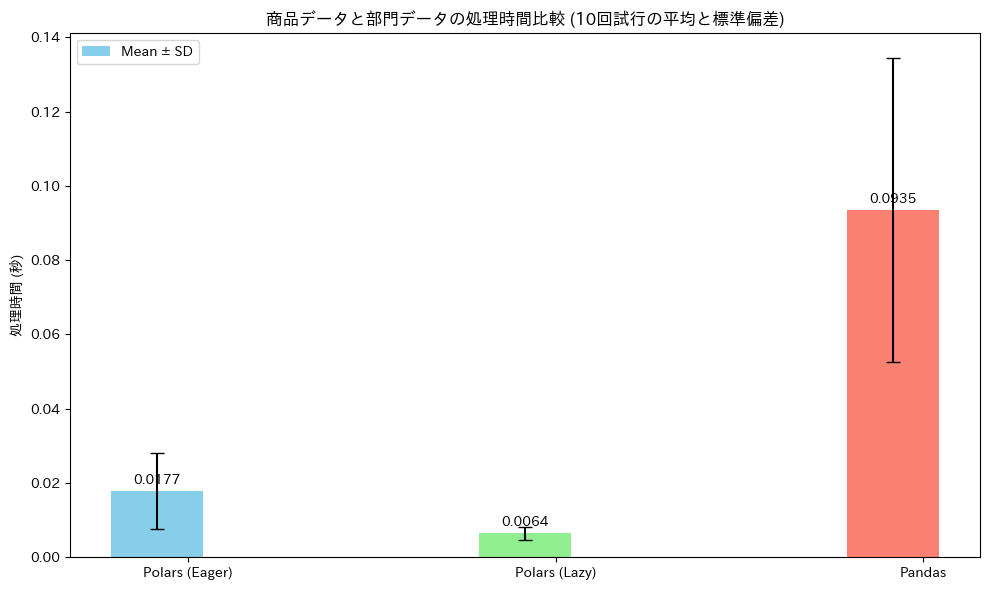

In [ ]:
labels = ['Polars (Eager)', 'Polars (Lazy)', 'Pandas']
means = [polars_eager_mean, polars_lazy_mean, pandas_mean]
stds = [polars_eager_std, polars_lazy_std, pandas_std]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/3, means, width, yerr=stds, capsize=5, label='Mean ± SD', color=['skyblue', 'lightgreen', 'salmon'])

ax.set_ylabel('処理時間 (秒)')
ax.set_title('商品データと部門データの処理時間比較 (10回試行の平均と標準偏差)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)

fig.tight_layout()
plt.show()


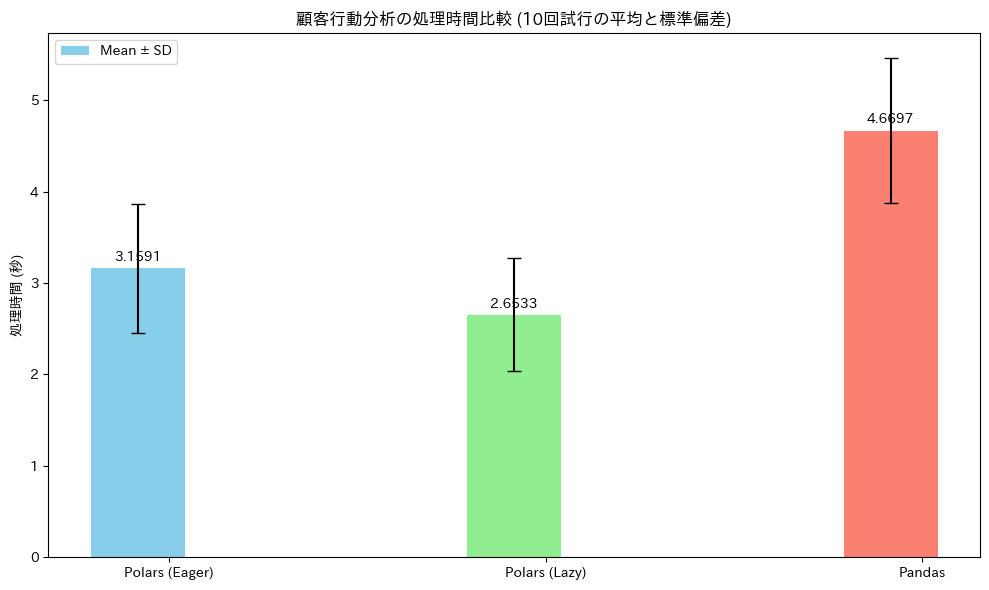

In [ ]:
labels = ['Polars (Eager)', 'Polars (Lazy)', 'Pandas']
means = [polars_eager_customer_mean, polars_lazy_customer_mean, pandas_customer_mean]
stds = [polars_eager_customer_std, polars_lazy_customer_std, pandas_customer_std]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/3, means, width, yerr=stds, capsize=5, label='Mean ± SD', color=['skyblue', 'lightgreen', 'salmon'])

ax.set_ylabel('処理時間 (秒)')
ax.set_title('顧客行動分析の処理時間比較 (10回試行の平均と標準偏差)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)

fig.tight_layout()
plt.show()